# Preprocess data

## 1. Extract data

In [1]:
import pandas as pd

In [2]:
from geopy import distance

In [3]:
# Load routes
routes = pd.read_csv("./data/routes.dat",
                      names = ["airline",
                              "airline_id",
                              "source_airport",
                              "source_airport_id",
                              "destination_airport",
                              "destination_airport_id",
                              "codeshare",
                              "stops",
                              "equipment"])

In [4]:
routes.head()

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [5]:
# Load airports 
airports = pd.read_csv("data/airports.dat",
                       names = ["airport_id", "Name", "City", "Country", "IATA",
                                "ICAO", "Latitude", "Longitude",
                                "Altitude", "Timezone", "DST",
                                "TzDatabase", "Type", "Source"])

In [6]:
airports.head()

,airport_id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TzDatabase,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [7]:
# clean the data
airports_routes = []
for i in list(set(routes['source_airport_id']) | set(routes['destination_airport_id'])):
    try:
        airports_routes.append(int(i))
    except:
        continue

airports_airports = list(airports['airport_id'])

airports_cleaned = list(set(airports_routes) & set(airports_airports))
airports_cleaned_str = [str(i) for i in airports_cleaned]

routes_cleaned = routes[routes['source_airport_id'].isin(airports_cleaned_str) & routes['destination_airport_id'].isin(airports_cleaned_str)]

airports_cleaned = airports[airports['airport_id'].isin(airports_cleaned)]

In [8]:
print(f'The original number of routes is {len(routes)}, and the reduced number of routes is {len(routes_cleaned)}')

The original number of routes is 67663, and the reduced number of routes is 66771


In [9]:
print(f'The original number of airports is {len(airports)}, and the reduced number of airports is {len(airports_cleaned)}')

The original number of airports is 7698, and the reduced number of airports is 3221


In [10]:
# save
routes_cleaned.to_csv('data/routes_cleaned.csv', index=False)
airports_cleaned.to_csv('data/airports_cleaned.csv', index=False)

## 2. Create graph

### 2.1 Create nodes

In [11]:
import numpy as np

In [12]:
# Get source and destination airports from routes
src_airports = routes_cleaned[["source_airport_id", "source_airport"]]
src_airports.columns = ["airport_id", "airport"]
dst_airports = routes_cleaned[["destination_airport_id", "destination_airport"]]
dst_airports.columns = ["airport_id", "airport"]

# Create nodes from airports
nodes = pd.concat([src_airports, dst_airports], axis = 0).drop_duplicates()
nodes.replace(to_replace = "\\N", value = np.NaN, inplace = True)
nodes.dropna(axis = 0, inplace = True)
nodes["airport_id"] = nodes["airport_id"].apply(int)

In [13]:
airports_cleaned.columns

Index(['airport_id', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude',
       'Longitude', 'Altitude', 'Timezone', 'DST', 'TzDatabase', 'Type',
       'Source'],
      dtype='object')

In [14]:
# Add latitudes, longitudes and continents to nodes
nodes = nodes.merge(right = airports_cleaned[["airport_id", "Latitude", "Longitude", "TzDatabase"]],
                    left_on = "airport_id",
                    right_on = "airport_id")

nodes.set_index("airport_id", inplace = True)
nodes["TzDatabase"] = nodes["TzDatabase"].str.split('/').str[0]

In [15]:
# Set proper names to columns and index of nodes
nodes.columns = ["Airport", "Latitude", "Longitude", "Continent"]
nodes.index.name = "Airport_id"

In [16]:
# Count number of nodes
N_NODES = nodes.shape[0]

In [17]:
N_NODES

3214

In [18]:
nodes.head()

,Airport,Latitude,Longitude,Continent
Airport_id,,,,
2965,AER,43.449902,39.956600,Europe
2966,ASF,46.283298,48.006302,Europe
2968,CEK,55.305801,61.503300,Asia
4029,DME,55.408798,37.906300,Europe
6156,EGO,50.643799,36.590099,Europe


### 2.2 Create edges

In [19]:
# Create edges from routes between airports
edges = routes_cleaned[["source_airport_id", "destination_airport_id"]]
edges = edges.replace(to_replace = "\\N", value = np.NaN)
edges.dropna(axis = 0, inplace = True)

# Convert edges id to int
edges["source_airport_id"] = edges["source_airport_id"].apply(int)
edges["destination_airport_id"] = edges["destination_airport_id"].apply(int)

In [20]:
edges.head()

,source_airport_id,destination_airport_id
0,2965,2990
1,2966,2990
2,2966,2962
3,2968,2990
4,2968,4078


In [21]:
# Create mapping from airport id to node id
airport_id2idx = pd.DataFrame(nodes.index.unique())
airport_id2idx = airport_id2idx.reset_index()\
                                .set_index("Airport_id")
airport_id2idx.columns = ["nodes_idx"]

In [22]:
# Add node_ids to edges for adjacency matrix construction
edges = edges.merge(right = airport_id2idx,
                   left_on = "source_airport_id",
                   right_index = True,
                   sort = False)

edges = edges.merge(right = airport_id2idx,
                   left_on = "destination_airport_id",
                   right_index = True,
                   sort = False,
                   suffixes = ["_src", "_dst"])

edges.drop_duplicates(inplace = True)

In [23]:
edges.head()

,source_airport_id,destination_airport_id,nodes_idx_src,nodes_idx_dst
0,2965,2990,0,7
1,2966,2990,1,7
3,2968,2990,2,7
5,4029,2990,3,7
10,6156,2990,4,7


## 3. Create adjacency matrix

### 3.1 Create non-weighted adjacency matrix

In [24]:
# Set all airports with connecting flights as neighbours
# in adjacency matrix
adjacency = np.zeros([N_NODES, N_NODES])
pairs = edges[["nodes_idx_src", "nodes_idx_dst"]].values.T
adjacency[tuple(pairs.tolist())] = 1
adjacency = (adjacency + adjacency.T) > 0

# Eliminate all self ending edges
adjacency = adjacency * (1 - np.identity(N_NODES))

In [25]:
adjacency.shape

(3214, 3214)

### 3.2 Create heat kernel weighted adjacency matrix

The heat kernel weighted adjacency matrix is computed from the laplacian, with each entry having the value $M_{ij}= e^{\frac{d_{ij}}{\sigma}}$

In [26]:
# Set sigma value 
sigma = 1200

In [27]:
# Calculate the distance between airports
dists = edges.merge(nodes[["Airport", "Latitude", "Longitude"]],
                   left_on = "source_airport_id",
                   right_index = True)

dists = dists.merge(nodes[["Airport", "Latitude", "Longitude"]],
                   left_on = "destination_airport_id",
                   right_index = True,
                   suffixes = ("_src", "_dst"))

dists["distance"] = dists.apply(lambda row: distance.geodesic(row[["Latitude_src", "Longitude_src"]].values,
                                                             row[["Latitude_dst", "Longitude_dst"]].values)\
                                                    .km,
                               axis = 1)

In [28]:
# Eliminate self ending edges' entries
dists = dists[dists.apply(lambda row: row["source_airport_id"] != row["destination_airport_id"],
                           axis = 1)]

In [29]:
# Obtain statistics of distance
dists[["distance"]].describe()

,distance
count,36906.000000
mean,1760.875394
std,1946.088833
min,2.832833
25%,571.716646
50%,1156.245634
75%,2092.216138
max,16089.885579


In [30]:
# Create heat kernel adjency matrix from distance
heat_kernel_adjacency = np.zeros((N_NODES, N_NODES))
pairs = dists[["nodes_idx_src", "nodes_idx_dst"]].values.T
heat_kernel_adjacency[tuple(pairs.tolist())] = np.exp(-dists["distance"] / sigma)
heat_kernel_adjacency 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
# Make the matrix symmetric
unsym_coors = np.array(np.where(heat_kernel_adjacency != heat_kernel_adjacency.T))

unsym_src = tuple(np.concatenate([unsym_coors, unsym_coors[::-1]], axis = 1).tolist())
unsym_tgt = tuple(np.concatenate([unsym_coors[::-1], unsym_coors], axis = 1).tolist())

heat_kernel_adjacency[unsym_src] += heat_kernel_adjacency[unsym_tgt]

## 3. Create adjacency matrix

In [32]:
import pickle
import networkx as nx
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

In [33]:
largest_cc = pickle.load(open('data/largest_cc.gpickle', 'rb'))

In [34]:
len(largest_cc.nodes)

3188

In [37]:
laplacian_nonweighted = nx.laplacian_matrix(largest_cc).asfptype()

In [38]:
def spectral_decomposition(laplacian, dim):
    k_eigenvalues, k_eigenvectors = scipy.sparse.linalg.eigsh(laplacian, k=1+dim, which='SA')
    eigenmap = k_eigenvectors[:,1:3]

    return eigenmap

In [39]:
eigenmap_nonweighted = spectral_decomposition(laplacian_nonweighted, 2)

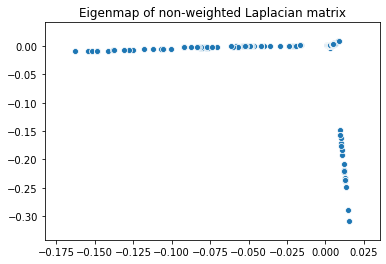

In [40]:
ax = sns.scatterplot(eigenmap_nonweighted[:,0], eigenmap_nonweighted[:,1])
ax.set_title('Eigenmap of non-weighted Laplacian matrix');

In [41]:
def compute_laplacian(adjacency):
    adj = (adjacency > 0).astype(int)
    degree_matrix = np.diag(np.sum(adj, axis=0))
    
    degree_inverse = np.linalg.pinv(degree_matrix)
    degree_inverse_sqrt = np.sqrt(degree_inverse)
    L = np.identity(adjacency.shape[0]) - np.dot(np.dot(degree_inverse_sqrt, adjacency), degree_inverse_sqrt)
    
    return L

In [42]:
heat_kernel_adjacency_conn = np.load('data/largest_cc_matrix.pkl.npy')

In [43]:
laplacian_norm_bg, D = sparse.csgraph.laplacian(heat_kernel_adjacency_conn, normed=True, return_diag=True)
D = np.diag(D)

computation_norm_bg =  scipy.linalg.eigh(laplacian_norm_bg)  #Compute orthonormale basis
eigenvectors_norm_bg = computation_norm_bg[1]
eigenvalues_norm_bg =  computation_norm_bg[0]

#Sort to have ordered eigenvalues
idx_norm_bg = eigenvalues_norm_bg.argsort()  
eigenvalues_norm_bg = np.round_(np.real(eigenvalues_norm_bg[idx_norm_bg]), 13)
eigenvectors_norm_bg = np.real(eigenvectors_norm_bg[:,idx_norm_bg])

#L*u = lambda*D*u
eigenvectors_u_bg = np.linalg.inv(D)@eigenvectors_norm_bg
eigenvalues_u_bg = eigenvalues_norm_bg

In [44]:
eigenvectors_u_bg.shape

(3188, 3188)

In [45]:
eigenmap_weighted = eigenvectors_u_bg[:,1:3]

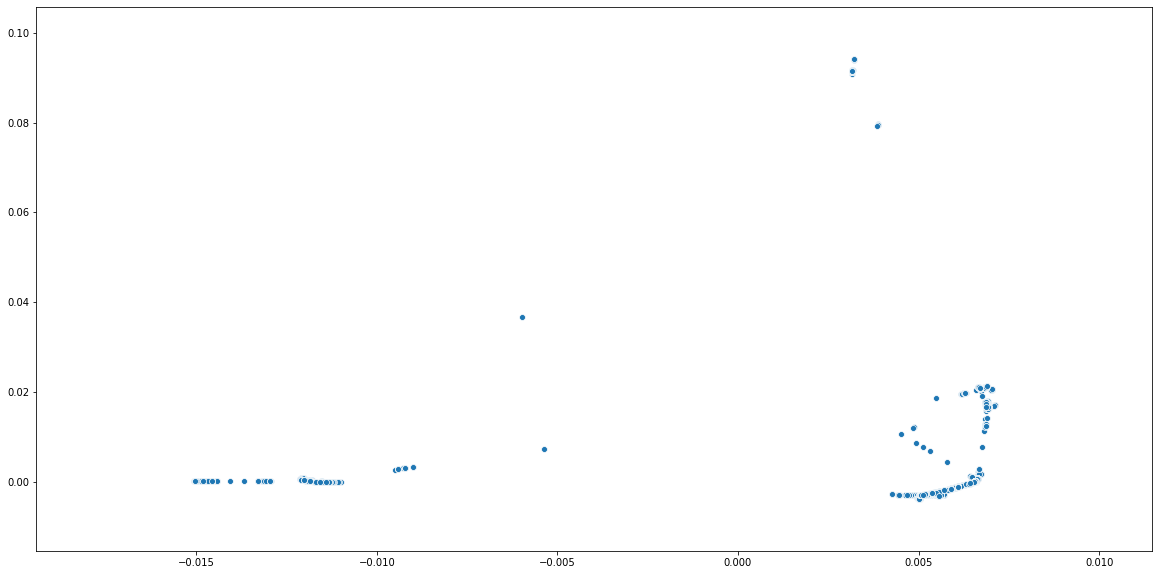

In [46]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(eigenmap_weighted[:,0], eigenmap_weighted[:,1])
ax.set_label('Eigenmap of weighted Laplacian matrix')

## K-means

In [47]:
from sklearn.cluster import KMeans
import folium

In [126]:
hub_center = np.load('continent_hubs.npy')

In [127]:
hub_center = hub_center[:-2]

In [128]:
hub_center

array([ 603,  117, 2005,  346,   52,  300,  429, 1537])

In [138]:
points = eigenvectors_u_bg[:, 1:3]
kmeans = KMeans(n_clusters=8, init=points[hub_center, :]) 
kmeans.fit(points);

/Users/caifengyu/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [139]:
res_predicted = kmeans.predict(points)

In [140]:
colorMap = {
    0: 'red',
    1: 'yellow',
    2: 'blue',
    3: 'green',
    4: 'orange',
    5: 'grey',
    6: 'black',
    7: 'pink'
}

In [141]:
color_map_kmeans = []

for con in res_predicted:
    color_map_kmeans.append(colorMap[con])

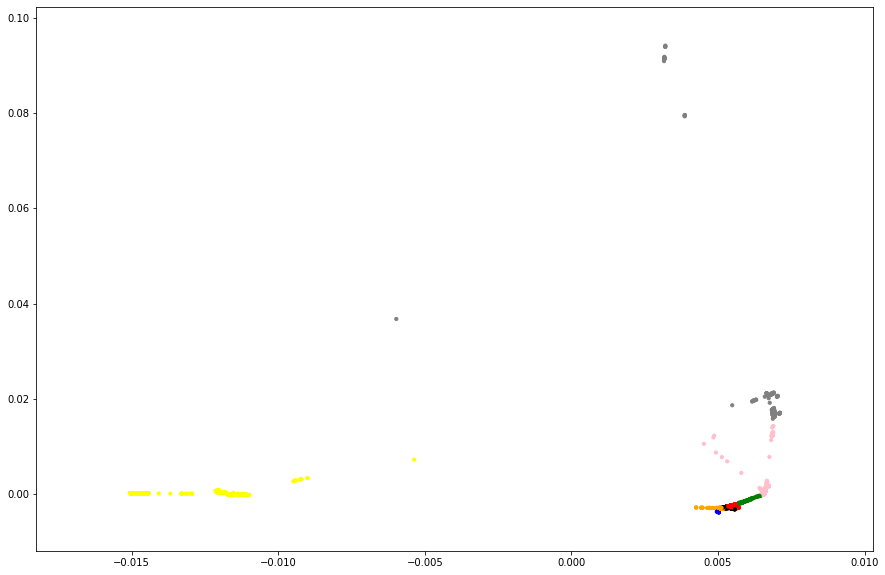

In [142]:
plt.figure(figsize=(15,10))
plt.scatter(eigenmap_weighted[:,0], eigenmap_weighted[:,1], s=10, c=color_map_kmeans)

In [143]:
mapping_index_airport = np.load('mapping.npy', allow_pickle=True)[()]

In [144]:
airports_key_id = airports_cleaned.set_index('airport_id')

In [145]:
map_test = folium.Map(tiles="openstreetmap")

# folium.GeoJson(
#     'data/continent.json',
#      style_function=lambda feature: {
#         'fillColor': feature['color'],
#         'color' : feature['color'],
#         'weight' : 1,
#         'fillOpacity' : 0.5,
#     },
#     name='geojson'
# ).add_to(map_test)

# folium.GeoJson(
#     'data/oceania_borders.json',
#      style_function=lambda feature: {
#         'fillColor': 'green',
#         'color' : 'green',
#         'weight' : 1,
#         'fillOpacity' : 0.5,
#     },
#     name='geojson'
# ).add_to(map_test)

for k, v in mapping_index_airport.items():
    airport = airports_key_id.loc[v]
    coord = [airport['Latitude'], airport['Longitude']]
    folium.CircleMarker(location=coord,
                        radius=1,
                        fill=True,
                        opacity=0.0,
                        fill_color=color_map_kmeans[k],
                        fill_opacity=0.7
                       ).add_to(map_test)

# for index, route in routes_cleaned.iterrows():    
#     src_info = airports_key_id.loc[int(route['source_airport_id'])]
#     des_info = airports_key_id.loc[int(route['destination_airport_id'])]
    
#     points = [[src_info['Latitude'], src_info['Longitude']], [des_info['Latitude'], des_info['Longitude']]]
#     folium.PolyLine(points, color="grey", weight=0.1, opacity=0.1).add_to(map_test)

In [146]:
map_test.save('k_8.html')